# Attention and Transformer model
In this notebook, we will look at the Transformer architecture using Attention technology (Article: [Attention is All You Need](https://arxiv.org/abs/1706.03762)). Let's implement this architecture with some (many) changes. We also recommend the following materials for a more detailed acquaintance [first](https://www.mihaileric.com/posts/transformers-attention-in-disguise/), [second](https://jalammar.github.io/illustrated-transformer/) and [third](http://nlp.seas.harvard.edu/2018/04/03/attention.html).

## Introduction

The beauty of the transformer architecture is that it is basically a seq-to-seq model, but not recurrent or autoregressive (i.e., each input and output is processed independently).

Transformer has become a state-of-the-art solution for many NLP tasks. In particular, pretrained Bert ([BERT](https://arxiv.org/abs/1810.04805)) is still used as a very good basic embedding for almost any NLP task.

In addition to Bert, there are many other powerful pre-trained transformers. They can be found in the [huggingface](https://huggingface.co/transformers/) library. A full list of models can be seen at this [link](https://huggingface.co/transformers/pretrained_models.html)



Connect to google drive and tensorboard

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [94]:
%reload_ext tensorboard
#!rm -rf /content/gdrive/MyDrive/runs
%tensorboard --logdir 'D:\\Notebooks\\Deep Learning School\\Module 5\\runs\\'

Reusing TensorBoard on port 6011 (pid 5392), started 0:00:39 ago. (Use '!kill 5392' to kill it.)

## Data processing

Let's solve news classification problem [AG_NEWS](https://paperswithcode.com/dataset/ag-news). The task: define the topik (4 topiks exist) of news - “World”, “Sports”, “Business”, “Sci/Tech”.

In [34]:
LOAD_LIBS = True
FIRST_START = True

In [2]:
if LOAD_LIBS:
  !pip install transformers -q
  !pip install datasets -q
  !pip install nltk -q
  !pip install pymorphy3 pymorphy3-dicts-ru -q
  import nltk
  nltk.download('stopwords')
  !pip install pymorphy2 -q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[nltk_data]     C:\Users\gosha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.ticker as ticker
from transformers import get_scheduler
import matplotlib.pyplot as plt

import numpy as np

import random
import math
import time
import string
import pymorphy3
import re

# datasets from huggingface
from datasets import load_dataset
from transformers import BertTokenizer, BertModel

from nltk.corpus import stopwords
import nltk

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import os
from datetime import datetime
from torch.nn.utils.rnn import pad_sequence

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
# BASE_FOLDER_PATH = 'gdrive/MyDrive'
BASE_FOLDER_PATH = os.getcwd()
BERT_MODEL_NAME = 'bert-base-cased'
BATCH_SIZE = 32
EPOCHS = 5
MODEL_NAME = 'model_v0'
LR = 0.00005
N_HEADS = 1
TRAIN_SIZE = 20000
TEST_SIZE = 1000

MODEL_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, MODEL_NAME)

SCHEDULER_LAMBDA_PARAM = 0.96
PAD_IND = 0
HIDDEN_DIM = 768

ENGLISH_STOP_WORDS = set(stopwords.words('english'))
PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer() # for preprocess

MORPH_ANALYZER = pymorphy3.MorphAnalyzer()

In [26]:
os.makedirs(MODEL_FOLDER_PATH, exist_ok=True)

In [27]:
# dataset load
dataset_dict = load_dataset('ag_news')
train_ds = dataset_dict['train'].select(range(TRAIN_SIZE))
test_ds = dataset_dict['test'].select(range(TEST_SIZE))

In [28]:
def preprocess_text(text):
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    punct_filtered_text = ''.join(
        [ch for ch in nums_filtered_text if ch not in string.punctuation]
    )
    tokens = PUNCT_WORD_TOKENIZER.tokenize(punct_filtered_text)
    filtr_stop_words_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens
                             if token not in ENGLISH_STOP_WORDS]
    norm_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in filtr_stop_words_tokens]

    return f"[CLS] {' '.join(norm_tokens)}"

Let's use Bert tokenizer as tokenizer. And 0 layer of Bert is used as embedding (only layer with embedding without encoder blocks).

Such tokenizer and embedding is used to simplify the code.



### Reusing model parts

We only want to use an *embedding* part of pretrained BERT model, so we need to extract *embedding* part of this model. It can be done using the following steps:

- Load pretrained model and inspect it's structure, using `transformers` library methods.

In [29]:
bert = BertModel.from_pretrained(BERT_MODEL_NAME)
bert

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

D:\Notebooks\.venv_Torch\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gosha\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Pretrained BERT model constists of multiple layers that are included in **3** main layers: `embedding`, `encoder`, `pooler` layers. To use `embedding` layer we need to refine model's structure.

- Delete `encoder` layers from `nn.ModuleList` construction;
- Transform `pooling` part into and *Identity* matrix that will only output it's unchanged inputs.

In [30]:
bert.pooler = nn.Identity()
del bert.encoder.layer[:]

bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList()
  )
  (pooler): Identity()
)

In [31]:
del bert

In [32]:
# Function for model transforms

def prepare_bert_tokenizer_and_embedder(bert_model_name, device=device):
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    bert_embedder = BertModel.from_pretrained(bert_model_name)
    bert_embedder.pooler = nn.Identity()
    del bert_embedder.encoder.layer[:]

    return tokenizer, bert_embedder.to(device)

tokenizer, embedder = prepare_bert_tokenizer_and_embedder(bert_model_name=BERT_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

### Prepare texts

Research text lengths. It could be necessary because we have to synchronize tokens sentence length. But we use Attention mechanism for these reason we can create mask for input tokens to ignore PAD tokens.

  0%|          | 0/20000 [00:00<?, ?it/s]

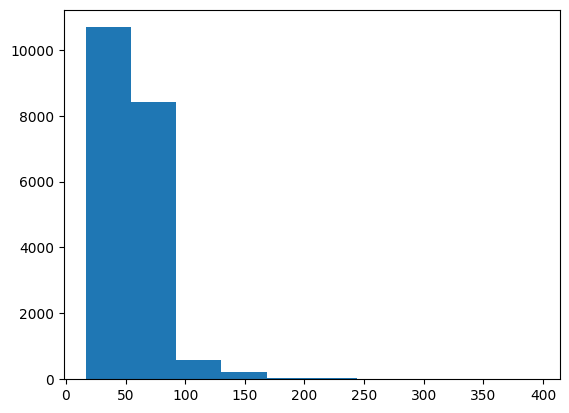

In [35]:
lengs = []
if FIRST_START:
  lengs = [len(tokenizer.tokenize(train_json['text'])) for train_json in tqdm(train_ds)]

if lengs:
  plt.hist(lengs)

Let's write function to create mask by lengths tensor.

In [58]:
def length_to_mask(length, max_len=None, dtype=None):
    """
    length: B.
    return B x max_len.
    If max_len is None, then max of length will be used.
    """
    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    # Create matrix constaining positional numbers, exapnd it to quantity of sequences in an input tensor and create boolean mask if lengths are not equal
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), int(max_len)) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask

In [47]:
a = torch.Tensor([1.0, 2.0, 3.0, 7.0, 10.0, 5., 10., 9.]).to(device)

In [48]:
length_to_mask(a)

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False]],
       device='cuda:0')

Next, let's create a cool set of dates. To keep things simple and inexpensive, write the following code so that it immediately returns the text presented in the video in accordance with the embedding sequence.

Also, for simplicity, this class will work with a date set object from library data sets (this can easily be corrected under any set of texts in a sequential task).

In [61]:
class MyDataset(Dataset):
  def __init__(self, hug_dataset, tokenizer, embedder=None, device=device):
    self.hug_dataset = hug_dataset # hugging dataset object
    self.tokenizer = tokenizer
    self.embedder = embedder
    self.device = device

  def __getitem__(self, idx):
    item_dict = self.hug_dataset[idx]
    text = item_dict['text']
    normalized_text = preprocess_text(text)
    target = item_dict['label']

    token_ids = self.text_to_tokens_ids(normalized_text)
    tokens_text_len = len(token_ids)
    # pad tokens to length
    if self.embedder:
        return self.embedder(token_ids.unsqueeze(0)), target, tokens_text_len

    return token_ids, target

  def text_to_tokens_ids(self, text):
    tokens = self.tokenizer.tokenize(text)

    return torch.tensor(self.tokenizer.convert_tokens_to_ids(tokens)).to(device)

  def __len__(self):
    return len(self.hug_dataset)

Write the `collate_fn` (function for DataLoader) to combine batch data to tensors with embeddings tensor, targets_tensor and lengths_tensor.

In [59]:
def collate_batch(batch):
  targets_list, embeddings_list, lengths_list = [], [], []

  for (_embed_output, _target, _text_len_in_tokens) in batch:
    _embed = _embed_output.last_hidden_state
    targets_list.append(_target)
    embeddings_list.append(_embed[0])
    lengths_list.append(_text_len_in_tokens)

  targets_tensor = torch.tensor(targets_list, dtype=torch.int64).to(device)
  embeddings_tensor = pad_sequence(embeddings_list, batch_first=True, padding_value=PAD_IND).to(device)
  lengths_tensor = torch.tensor(lengths_list, dtype=torch.int64).to(device)

  return embeddings_tensor.detach(), targets_tensor.detach(), lengths_tensor

Create dataset and dataloader objects.

In [62]:
train_dataset = MyDataset(train_ds, tokenizer=tokenizer, embedder=embedder)
test_dataset = MyDataset(test_ds, tokenizer=tokenizer, embedder=embedder)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_batch, drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=3, collate_fn=collate_batch, drop_last=True)

In [63]:
sentence_samples_to_show_attention = [train_ds[1129], train_ds[4534]]
sentence_samples_to_show_attention = [sent['text'] for sent in sentence_samples_to_show_attention]

## Model creation

Create the Transform model only with PyTorch library. Let's remember how Attention works.

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`.

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

In [65]:
a = torch.randn((4, 3, 2))

In [68]:
a

tensor([[[-0.0788,  0.6751],
         [ 0.6586,  0.1184],
         [-2.1907, -0.1490]],

        [[ 0.4754, -0.8195],
         [ 0.6580,  0.3679],
         [-0.6706, -1.8296]],

        [[-3.3172, -1.2574],
         [ 1.3570,  2.3616],
         [-0.6565,  1.1651]],

        [[ 1.0033, -0.3720],
         [-1.5803, -0.3975],
         [-0.7153,  0.5024]]])

In [72]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim) # -> [batch_size, seq_len, num_heads, headd_dim]
        K = K.view(batch_size, -1, self.n_heads, self.head_dim) # -> [batch_size, seq_len, num_heads, head_dim]
        V = V.view(batch_size, -1, self.n_heads, self.head_dim) # -> [batch_size, seq_len, num_heads, head_dim]

        Q = Q.permute(0, 2, 1, 3) # -> [batch_size, num_heads, query_length, head_dim]
        K = K.permute(0, 2, 1, 3) # -> [batch_size, num_heads, key_length, head_dim]
        V = V.permute(0, 2, 1, 3) # -> [batch_size, num_heads, value_length, head_dim]
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale # multiply [batch_size, num_heads, query_length, head_dim] x [batch_size, num_heads, head_dim, key_length]

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            mask = mask[:, None, None, :] # -> [batch_size, 1, 1, key_length]
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

***Question:*** Is the Python class for Encoder self-attention, Decoder self-attention or attention between Encoder and Decoder?

Based on self-attention idea let's construct easy classification model: self-attention on the bert embedings, result of attention for 0 token is used in the linear classification layer.

In [73]:
class SelfAttentionBasedClassifier(nn.Module):
  def __init__(self, hid_dim, cnt_class=4, device=device, n_heads=N_HEADS):
    super().__init__()
    self.hid_dim = hid_dim
    self.device = device
    self.cnt_class = cnt_class
    self.attn = MultiHeadAttentionLayer(hid_dim=self.hid_dim, n_heads=n_heads, dropout=0, device=self.device)
    self.classifier_head = nn.Linear(self.hid_dim, self.cnt_class)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask = None):
    x, attention = self.attn(x, x, x, mask=mask)
    # let's classifier by 0 token information
    # Reason of 0 token
    x = x[:, 0, :].squeeze()
    x = self.classifier_head(x)

    #return self.softmax(x), attention
    return x, attention

In [74]:
model = SelfAttentionBasedClassifier(HIDDEN_DIM).to(device)

Write functions for display attention matrixes

In [75]:
def get_attention_fig(sentence, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(12 * n_cols, 12 * n_rows))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ticks = [t.lower() for t in sentence]
        ax.set_xticklabels(ticks,
                           rotation=45)
        ax.set_yticklabels(ticks)

        ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticks))
        ax.yaxis.set_major_formatter(ticker.FixedFormatter(ticks))
        #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    return fig

In [76]:
def display_attention_examples(
    tb_writer,
    texts=sentence_samples_to_show_attention,
    tokenizer=tokenizer,
    embedder=embedder,
    n_heads=N_HEADS,
    n_rows=1,
    n_cols=1):
  cur_dataset = MyDataset([{'text': text, 'label': -1} for text in texts], tokenizer, embedder)
  cur_dataloader = DataLoader(cur_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)

  with torch.no_grad():
    for text, data in zip(texts, cur_dataloader):
        input_data, _, lengths = data
        mask = length_to_mask(lengths)

        input_data = input_data.to(device)
        outputs, attention = model(input_data, mask=mask)

        att_fig = get_attention_fig(tokenizer.tokenize(text), attention, n_heads=n_heads, n_rows=n_rows, n_cols=n_cols)
        tb_writer.add_figure(f'Text attention: {text}', att_fig)

Let's write functions for training and validation process.

In [77]:
loss_fn = torch.nn.CrossEntropyLoss()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
optimizer = optim.Adam(model.parameters(), lr=LR)

lambda_scheduler = lambda x: SCHEDULER_LAMBDA_PARAM ** x
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

writer = SummaryWriter(os.path.join(BASE_FOLDER_PATH, 'runs/{}'.format(MODEL_NAME)))

def train_one_epoch(epoch_index, model, training_loader, scheduler, optimizer, loss_fn, tb_writer):
    running_loss = 0.
    last_loss = 0.
    train_loss = 0.

    i = 0
    cnt_right_answers = 0
    cnt_answers = 0

    all_answers = []
    answers_probs = []
    all_labels = []
    for data in tqdm(training_loader):
        input_data, labels, lengths = data
        mask = length_to_mask(lengths)

        if epoch_index != -1:
            optimizer.zero_grad()
        input_data = input_data.to(device)
        labels = labels.to(device).long()
        outputs, attention = model(input_data, mask=mask)

        answers = outputs.argmax(axis=-1)
        loss = loss_fn(outputs, labels)
        if epoch_index != -1:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()
        if i % 10 == 9 and epoch_index != -1:
            last_loss = running_loss / 10 # loss per batch
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

            if i % 10 == 0 and scheduler is not None:
                tb_writer.add_scalar('Scheduler LR', optimizer.param_groups[0]["lr"], tb_x)
                scheduler.step()
            if i % 100 == 99:
                display_attention_examples(tb_writer)

        cnt_answers += labels.shape[0]
        cnt_right_answers += (answers == labels).sum().item()

        i += 1

    train_loss = train_loss / len(training_loader)
    tb_writer.add_scalar('Accuracy/train', cnt_right_answers / cnt_answers, epoch_index + 1)

    return train_loss


def validation(epoch_number, val_dataloader):
    val_loss = 0.0

    all_answers = []
    answers_probs = []
    all_labels = []

    cnt_answers = 0
    cnt_right_answers = 0
    model.eval()
    with torch.no_grad():
        for i, vdata in tqdm(enumerate(val_dataloader)):
            input_data, labels, lengths = vdata
            mask = length_to_mask(lengths)

            optimizer.zero_grad()
            input_data = input_data.to(device)
            labels = labels.to(device).long()
            outputs, attention = model(input_data, mask=mask)

            vloss = loss_fn(outputs, labels)
            val_loss += vloss.item()
            answers = outputs.argmax(axis=-1)

            cnt_answers += labels.shape[0]
            cnt_right_answers += (answers == labels).sum().item()

            del input_data, labels, lengths

    val_loss = val_loss / len(val_dataloader)
    print("VAL LOSS =", val_loss)
    return val_loss, cnt_right_answers / cnt_answers

Let's start train loop

In [ ]:
best_vloss = 1_000_000.

for epoch_number in tqdm(range(EPOCHS)):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train()
    train_loss = train_one_epoch(
        epoch_index=epoch_number,
        model=model,
        training_loader=train_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn=loss_fn,
        tb_writer=writer)

    model.eval()
    val_loss, val_acc = validation(epoch_number, test_dataloader)

    writer.add_scalar('Loss/valid', val_loss, epoch_number + 1)
    writer.add_scalar('Accuracy/valid', val_acc, epoch_number + 1)
    if val_loss < best_vloss:
        best_vloss = val_loss
        model_path = os.path.join(MODEL_FOLDER_PATH, 'model_{}_{}'.format(epoch_number + 1, timestamp))
        torch.save(model.state_dict(), model_path)


In [79]:
display_attention_examples()

TypeError: display_attention_examples() missing 1 required positional argument: 'tb_writer'

##Train the BERT model for this task



In [81]:
%tensorboard runs

UsageError: Line magic function `%tensorboard` not found.


In [80]:
BASE_FOLDER_PATH

'D:\\Notebooks\\Deep Learning School\\Module 5'

This code is based on the [example](https://huggingface.co/docs/transformers/tasks/sequence_classification) from huggingface.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm.auto import tqdm

In [ ]:
del model, tokenizer, optimizer, scheduler  # delete our previous objects

In [ ]:
# download pretrained models
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4).to(device)
for w in model.distilbert.parameters():
    w._trainable= False
for w in model.classifier.parameters():
    w._trainable = True

### Prepare dataset

In [ ]:
dataset_dict = load_dataset('ag_news')
train_ds = dataset_dict['train']
test_ds = dataset_dict['test']

In [ ]:
def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(
        examples["text"],
        padding="max_length",
        max_length=512,
        truncation=True,
        return_token_type_ids="token_type_ids" in tokenizer.model_input_names)

def ds_object_process(ds_obj):
  return ds_obj.map(
        tokenize_function, batched=True
      ).remove_columns(["text"]).rename_column("label", "labels")

# Take small train to speed up train
tokenized_train_dataset = ds_object_process(train_ds.select(range(500)))
tokenized_train_dataset.set_format("torch")
tokenized_test_dataset = ds_object_process(test_ds.select(range(TEST_SIZE)))
tokenized_test_dataset.set_format("torch")

Create dataloaders, optimizer and scheduler

In [ ]:
train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=BATCH_SIZE)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=LR)
num_training_steps = EPOCHS * len(train_dataloader)
scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

Run train loop

In [ ]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(3):
    train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        train_loss += loss.item()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_loss /= len(train_dataloader)
    print(f'EPOCH {epoch}: train_loss={train_loss}')

Run validation

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")
model.eval()
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()